# DAT350 Compulsory 2 - Erlend Risvik

We start by loading the data and doing some quick exploration.

In [2]:
import pandas as pd
df = pd.read_csv('data/colon.csv', sep=',', index_col=0)
df.head()

,id,study,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,etype
1,1,1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,1521,2
2,1,1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,968,1
3,2,1,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,2
4,2,1,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,1
5,3,1,Obs,0,71,0,0,1,7.0,1,2.0,2,0,1,963,2


In [3]:
# Start by subetting data where etype == 2
df = df[df['etype'] == 2]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 929 entries, 1 to 1857
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        929 non-null    int64  
 1   study     929 non-null    int64  
 2   rx        929 non-null    object 
 3   sex       929 non-null    int64  
 4   age       929 non-null    int64  
 5   obstruct  929 non-null    int64  
 6   perfor    929 non-null    int64  
 7   adhere    929 non-null    int64  
 8   nodes     911 non-null    float64
 9   status    929 non-null    int64  
 10  differ    906 non-null    float64
 11  extent    929 non-null    int64  
 12  surg      929 non-null    int64  
 13  node4     929 non-null    int64  
 14  time      929 non-null    int64  
 15  etype     929 non-null    int64  
dtypes: float64(2), int64(13), object(1)
memory usage: 123.4+ KB


Observe there are a few NA columns. Let's remove them for now.

In [5]:
df.describe()

,id,study,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,etype
count,929.000000,929.0,929.000000,929.000000,929.000000,929.000000,929.000000,911.000000,929.000000,906.000000,929.000000,929.000000,929.000000,929.000000,929.0
mean,465.000000,1.0,0.520990,59.754575,0.193757,0.029064,0.145318,3.659715,0.486545,2.062914,2.886975,0.265877,0.274489,1669.955867,2.0
std,268.323499,0.0,0.499828,11.948887,0.395453,0.168075,0.352611,3.572562,0.500088,0.514340,0.488149,0.442037,0.446497,872.098960,0.0
min,1.000000,1.0,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,23.000000,2.0
25%,233.000000,1.0,0.000000,53.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000,0.000000,806.000000,2.0
50%,465.000000,1.0,1.000000,61.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1976.000000,2.0
75%,697.000000,1.0,1.000000,69.000000,0.000000,0.000000,0.000000,5.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2364.000000,2.0
max,929.000000,1.0,1.000000,85.000000,1.000000,1.000000,1.000000,33.000000,1.000000,3.000000,4.000000,1.000000,1.000000,3329.000000,2.0


In [6]:
df.dropna(axis=0, inplace=True)

We start by binning the age column

In [7]:
# map the status column to true/false
df['status'] = df['status'].map({0: False, 1: True}) 

# bin age
df['age_groups'] = pd.qcut(df['age'], q=[0, 0.34, 0.67, 1], labels=['Young', 'MiddleAge', 'Older'])
df['age_groups'].value_counts()

age_groups
Young        307
MiddleAge    294
Older        287
Name: count, dtype: int64

In [8]:
excluded_covariates = ['id', 'study', 'time', 'status', 'age', 'nodes', 'etype'] # study is constant. We also use age_binned instead of age.
covariates = [col for col in df.columns if col not in excluded_covariates]

for covariate in covariates:
    print("-----------------------")
    print(f"Covariate: {covariate}\nUnique categories: ")
    for cat in df[covariate].unique():
        print(cat)

-----------------------
Covariate: rx
Unique categories: 
Lev+5FU
Obs
Lev
-----------------------
Covariate: sex
Unique categories: 
1
0
-----------------------
Covariate: obstruct
Unique categories: 
0
1
-----------------------
Covariate: perfor
Unique categories: 
0
1
-----------------------
Covariate: adhere
Unique categories: 
0
1
-----------------------
Covariate: differ
Unique categories: 
2.0
3.0
1.0
-----------------------
Covariate: extent
Unique categories: 
3
2
1
4
-----------------------
Covariate: surg
Unique categories: 
0
1
-----------------------
Covariate: node4
Unique categories: 
1
0
-----------------------
Covariate: age_groups
Unique categories: 
Young
MiddleAge
Older


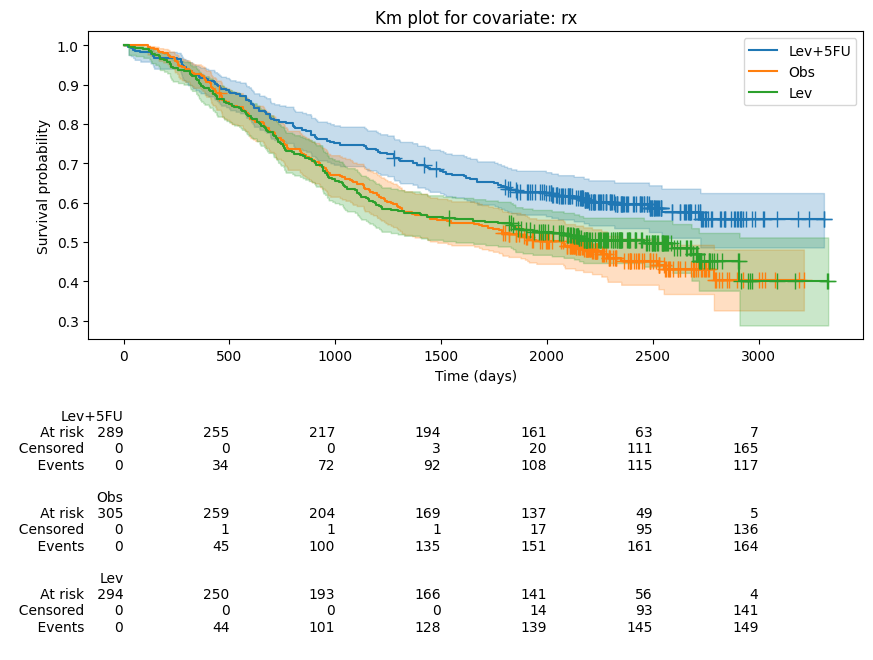

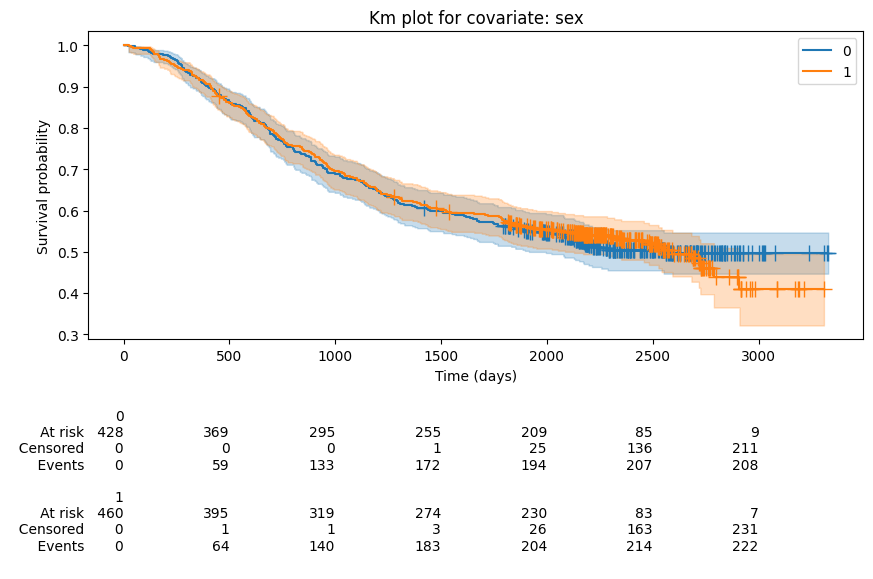

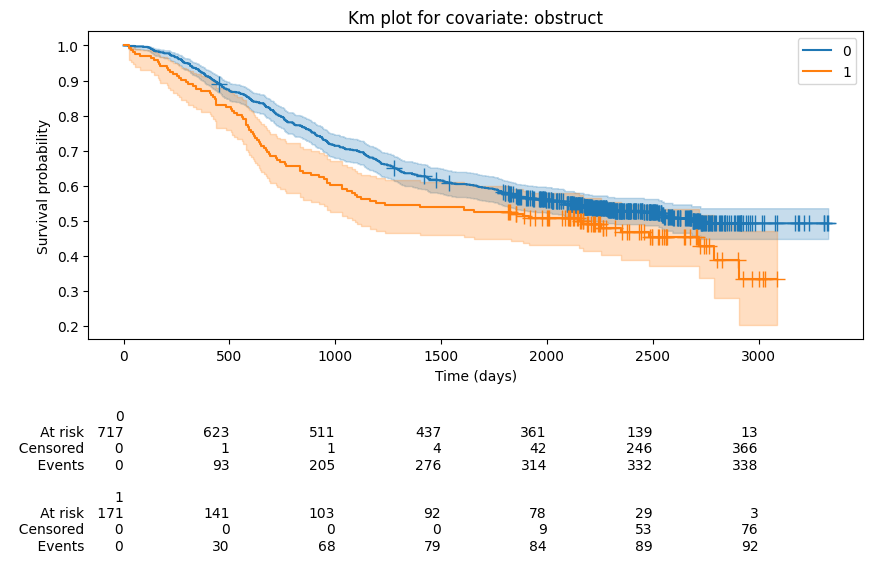

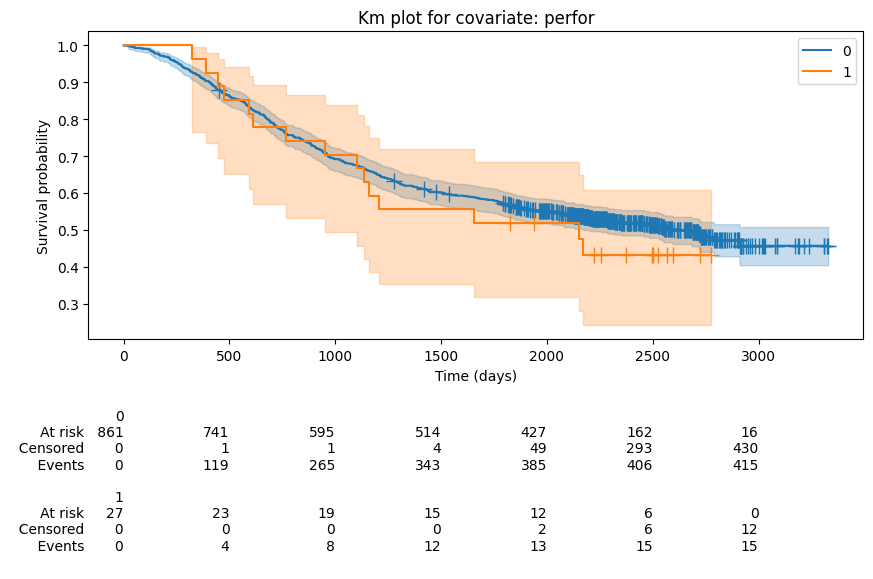

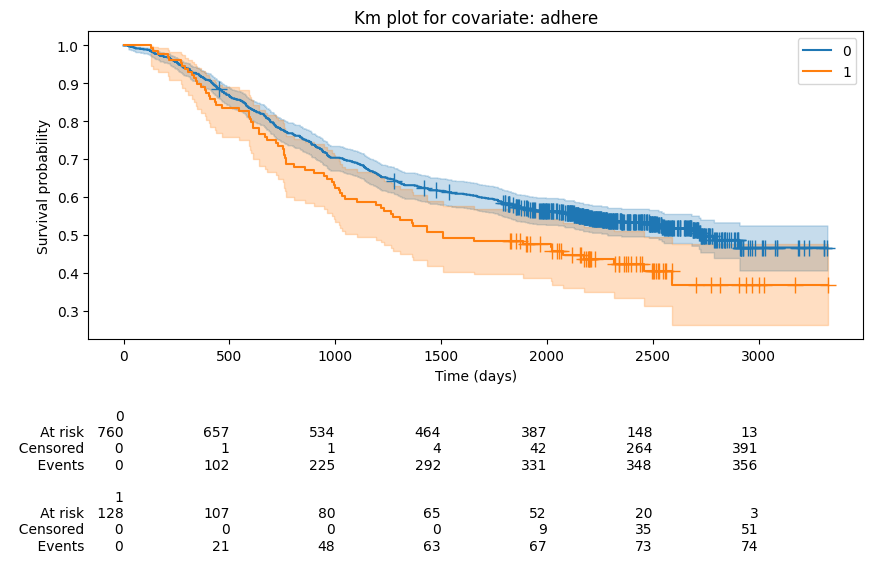

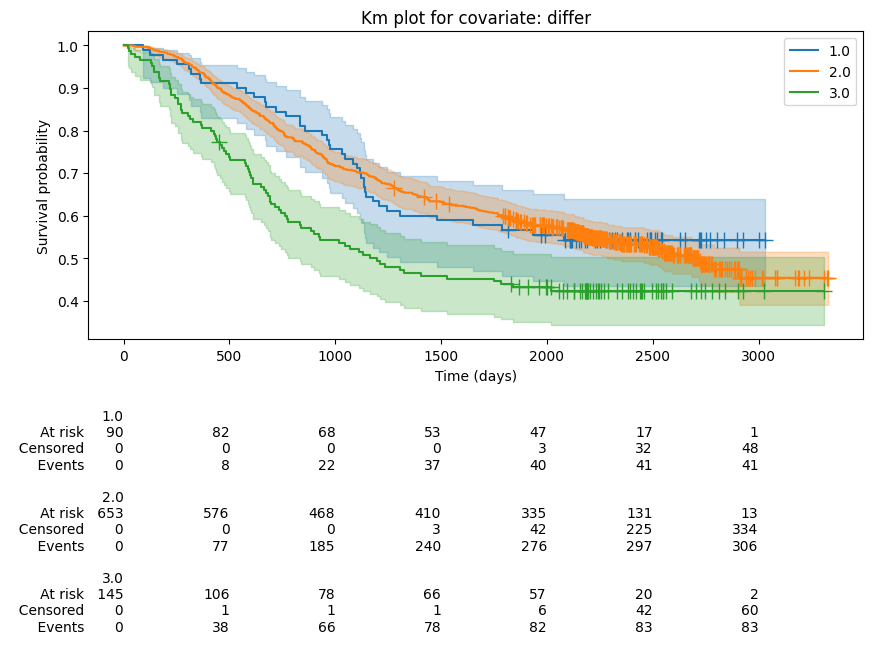

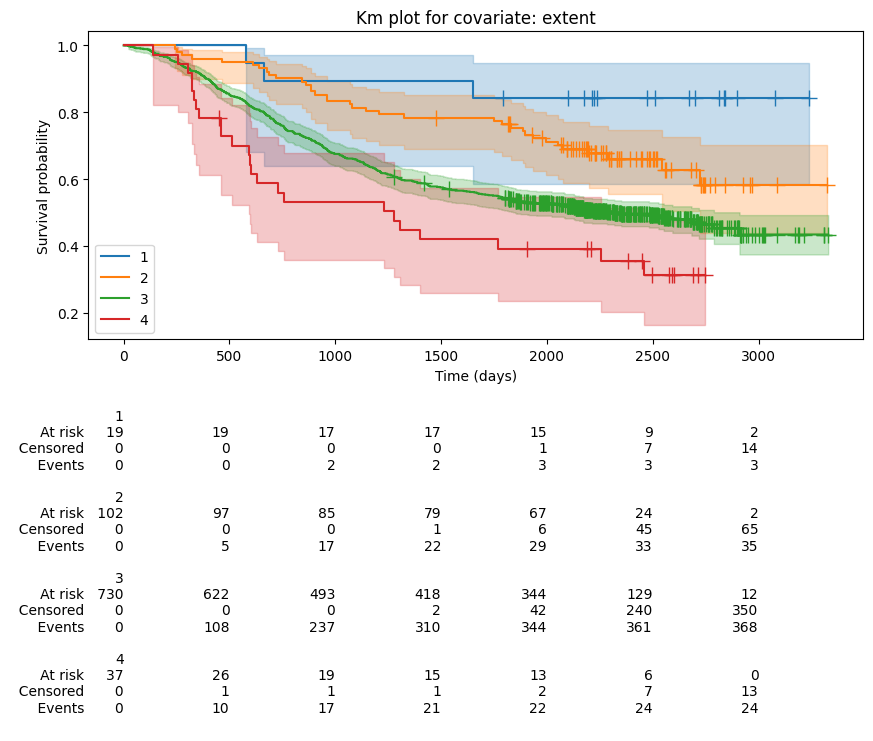

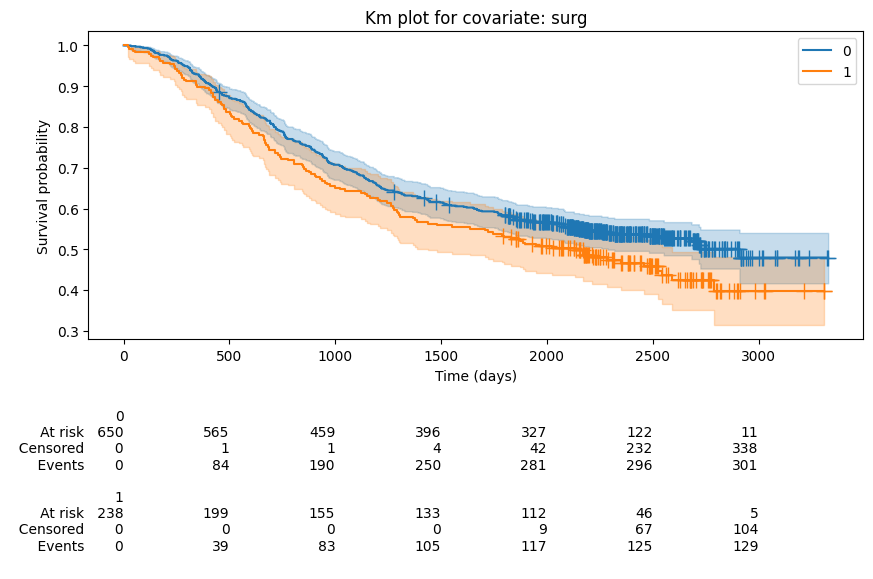

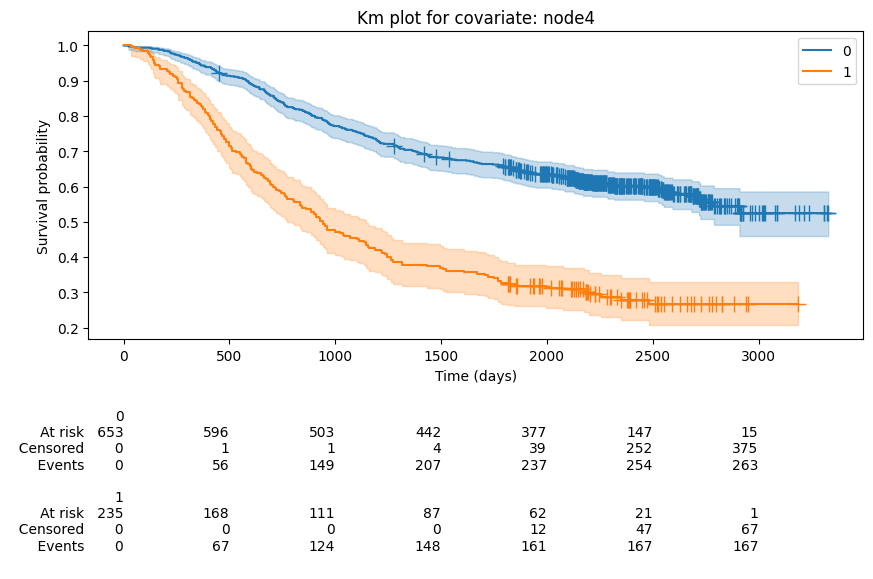

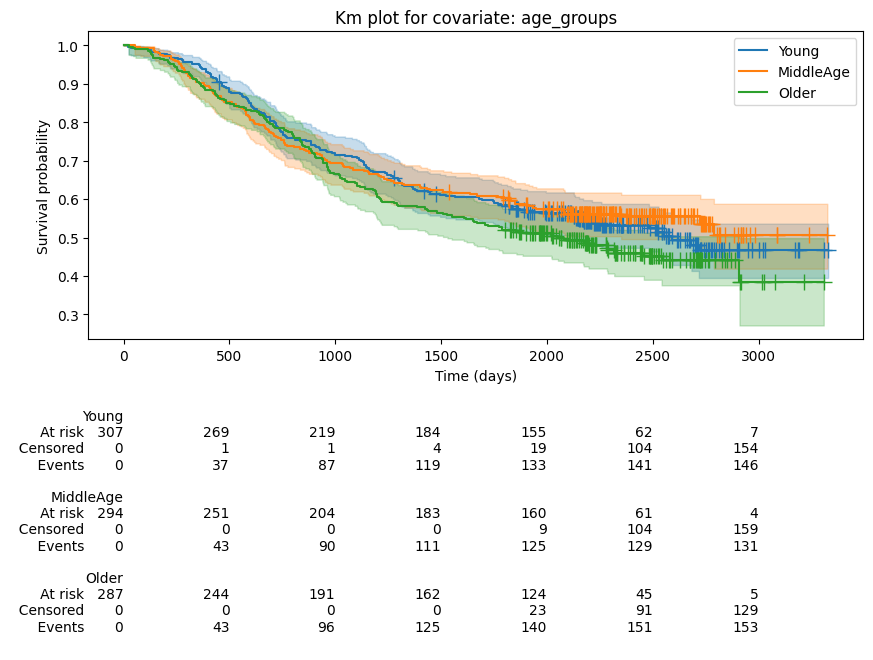

In [9]:
# Plotting of Kaplan-Meier curves based on the covariates features (make sure that censored individuals are shown)
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.plotting import add_at_risk_counts

# create a dict that sorts the covariates (there are also categorical covariates)
sorted_covariates = {'rx': ['Lev+5FU', 'Obs', 'Lev'],
                     'age_groups': ['Young', 'MiddleAge', 'Older']}

for covariate in covariates:
    fig, ax = plt.subplots(figsize=(10, 4))
    
    models = []
    for idx, covariate_value in enumerate(sorted(df[covariate].unique())):
        if covariate in sorted_covariates.keys():
            covariate_value = sorted_covariates[covariate][idx]
            
        mod = KaplanMeierFitter()
        mod.fit(durations = df[df[covariate] == covariate_value]['time'], 
                event_observed = df[df[covariate] == covariate_value]['status'],
                label=covariate_value)
        mod.plot_survival_function(ax=ax, show_censors=True,
                                   title=f"Km plot for covariate: {covariate}",
                                   ylabel="Survival probability",
                                   xlabel="Time (days)")
        models.append(mod)

    add_at_risk_counts(*models, ax=ax)
    plt.show()

In [11]:
# carry out log-rank test for each covariate
from lifelines.statistics import logrank_test, multivariate_logrank_test

for covariate in covariates:
    if len(df[covariate].unique())<=2:
        print(f"Log-rank test for covariate: {covariate}")
        print(logrank_test(df[df[covariate] == df[covariate].unique()[0]]['time'], 
                           df[df[covariate] == df[covariate].unique()[1]]['time'], 
                           df[df[covariate] == df[covariate].unique()[0]]['status'], 
                           df[df[covariate] == df[covariate].unique()[1]]['status']))
    else:
        print(f"Multivariate log-rank test for covariate: {covariate}")
        print(multivariate_logrank_test(df['time'], df[covariate], df['status']))
afwaf


Multivariate log-rank test for covariate: rx
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          11.02 <0.005      7.95
Log-rank test for covariate: sex
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.94      0.10
Log-rank test for covariate: obstruct
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.50 0.03      4.88
Log-rank test for covariate: perfor
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name 